In [1]:
# ================= Cell 1 =================
# CLARITY - Step 1: Environment Setup, Imports, Device Configuration

import os
import json
import time
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from collections import defaultdict

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision import models

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    f1_score, accuracy_score, roc_auc_score, 
    precision_score, recall_score, classification_report
)

# ========== CONFIGURATION ==========
BASE_DIR = r"D:\Projects\CLARITY\Model\Dataset\archive"
CSV_PATH = r"D:\Projects\CLARITY\Model\Dataset\archive\Data_Entry_2017.csv"
OUTPUT_DIR = r"./outputs_best_model"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# ========== HYPERPARAMETERS ==========
SEED = 42
BATCH_SIZE = 16
IMAGE_SIZE = 224
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# ========== REPRODUCIBILITY ==========
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ========== DEVICE ==========
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("="*70)
print("CLARITY - DenseNet121 Multi-Label Classification")
print("="*70)
print(f"BASE_DIR: {BASE_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")
print(f"Device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")
print(f"SEED: {SEED}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Image Size: {IMAGE_SIZE}")
print("="*70)

CLARITY - DenseNet121 Multi-Label Classification
BASE_DIR: D:\Projects\CLARITY\Model\Dataset\archive
OUTPUT_DIR: ./outputs_best_model
Device: cuda
PyTorch version: 2.7.1+cu118
SEED: 42
Batch Size: 16
Image Size: 224


In [2]:
# ================= Cell 2 =================
# Load CSV, Parse Labels, Build Metadata (CORRECTED for images_*/images/ structure)

print("\n[STEP 2] Loading and preparing dataset...")

# ========== LOAD CSV ==========
df = pd.read_csv(CSV_PATH)
print(f"✅ CSV loaded: {df.shape}")
print(df.head(3))

# ========== EXTRACT COLUMNS & PARSE LABELS ==========
df = df[['Image Index', 'Finding Labels', 'Patient ID']].copy()

# Split multi-label strings into lists
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

# Get all unique disease labels
all_labels = sorted(set([l for sublist in df['Finding Labels'] for l in sublist]))

print(f"\n✅ Total unique disease labels: {len(all_labels)}")
print(f"Labels: {all_labels}")

# ========== MULTI-LABEL BINARIZATION ==========
mlb = MultiLabelBinarizer(classes=all_labels)
label_matrix = mlb.fit_transform(df['Finding Labels'])
label_cols = mlb.classes_

# Add binary columns to dataframe
df = pd.concat([df, pd.DataFrame(label_matrix, columns=label_cols)], axis=1)

print(f"\n✅ Final dataframe shape: {df.shape}")
print(f"Label columns ({len(label_cols)}): {list(label_cols)}")

# ========== BUILD IMAGE PATH CACHE (CORRECT STRUCTURE) ==========
print("\n[Building image path cache with glob...]")

img_lookup = {}

# CORRECT: Pattern for images_*/images/*.png structure
pattern = os.path.join(BASE_DIR, "images_*", "images", "*.png")
print(f"   Glob pattern: {pattern}")

all_images = glob.glob(pattern)
print(f"   Found {len(all_images)} images via glob")

for img_path in all_images:
    fname = os.path.basename(img_path)
    img_lookup[fname] = img_path

print(f"✅ Image cache built: {len(img_lookup)} images indexed")

# ========== ASSIGN IMAGE PATHS TO DATAFRAME ==========
print("\n[Mapping image paths to dataframe records...]")

img_paths = []
missing_count = 0

for idx_name in df['Image Index']:
    if idx_name in img_lookup:
        img_paths.append(img_lookup[idx_name])
    else:
        img_paths.append(None)
        missing_count += 1

df['img_path'] = img_paths

print(f"✅ Image paths assigned")
print(f"   Total records: {len(df)}")
print(f"   With valid paths: {len(df) - missing_count}")
print(f"   Missing paths: {missing_count}")

# ========== REMOVE RECORDS WITH MISSING IMAGES ==========
df_before = len(df)
df = df[df['img_path'].notna()].reset_index(drop=True)
df_after = len(df)

print(f"\n✅ After removing missing images:")
print(f"   Removed: {df_before - df_after} records")
print(f"   Remaining: {df_after} samples")

# ========== VALIDATE DATASET ==========
print(f"\n✅ Dataset prepared successfully!")
print(f"   Shape: {df.shape}")
print(f"   Patients: {df['Patient ID'].nunique()}")
print(f"   Label distribution (first 8):")

for i, label in enumerate(label_cols[:8]):
    count = df[label].sum()
    pct = 100 * count / len(df)
    print(f"      {i+1:2d}. {label:20s}: {count:6.0f} ({pct:5.1f}%)")

# ========== VERIFY SAMPLE PATHS ==========
print(f"\n[Sample path verification]")
sample_paths = df['img_path'].sample(min(5, len(df)), random_state=SEED)
for i, path in enumerate(sample_paths.values, 1):
    exists = os.path.exists(path)
    size_kb = os.path.getsize(path) / 1024 if exists else 0
    status = "✅" if exists else "❌"
    print(f"   {status} Sample {i}: {os.path.basename(path)} ({size_kb:.1f} KB)")

print("\n" + "="*70)


[STEP 2] Loading and preparing dataset...
✅ CSV loaded: (112120, 12)
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0                        0.143  0.143          NaN  
1                        0.143  0.143          NaN  
2                        0.168  0.168          NaN  

✅ Total unique disease labels: 15
Labels: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphys

In [3]:
# ================= Cell 3 =================
# Train/Val/Test Split by Patient ID (NO DATA LEAKAGE) + DataLoaders

print("\n[STEP 3] Patient-level split and DataLoader creation...")

# ========== PATIENT-LEVEL SPLITTING ==========
# Critical: Split by Patient ID to prevent data leakage
patients = df['Patient ID'].unique()
print(f"\nTotal unique patients: {len(patients)}")

# 70% train, 15% val, 15% test
train_patients, temp_patients = train_test_split(
    patients, test_size=0.3, random_state=SEED
)
val_patients, test_patients = train_test_split(
    temp_patients, test_size=0.5, random_state=SEED
)

# Create dataframes for each split
train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

print(f"\n✅ Patient-Level Split:")
print(f"   Train: {len(train_df):6d} images from {len(train_patients):5d} patients ({100*len(train_df)/len(df):.1f}%)")
print(f"   Val:   {len(val_df):6d} images from {len(val_patients):5d} patients ({100*len(val_df)/len(df):.1f}%)")
print(f"   Test:  {len(test_df):6d} images from {len(test_patients):5d} patients ({100*len(test_df)/len(df):.1f}%)")

# Verify no patient overlap
print(f"\n✅ Verification (no data leakage):")
print(f"   Train ∩ Val patients: {len(set(train_patients) & set(val_patients))}")
print(f"   Train ∩ Test patients: {len(set(train_patients) & set(test_patients))}")
print(f"   Val ∩ Test patients: {len(set(val_patients) & set(test_patients))}")

# ========== DATA AUGMENTATIONS ==========
train_transforms = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(15),
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomResizedCrop(IMAGE_SIZE, scale=(0.85, 1.0)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

print(f"\n✅ Data augmentations configured")

# ========== CUSTOM DATASET CLASS ==========
class ChestXrayDataset(Dataset):
    """Multi-label chest X-ray dataset"""
    
    def __init__(self, dataframe, label_cols, transform=None):
        """
        Args:
            dataframe: DataFrame with image paths and labels
            label_cols: List of disease label column names
            transform: Image transformations
        """
        self.df = dataframe.reset_index(drop=True)
        self.label_cols = label_cols
        self.transform = transform
        self.img_paths = dataframe['img_path'].values
        self.labels = dataframe[label_cols].values.astype(np.float32)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load image
        img_path = self.img_paths[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Warning: Failed to load {img_path}: {e}")
            image = Image.new('RGB', (IMAGE_SIZE, IMAGE_SIZE), color='black')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        # Get labels
        labels = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        return image, labels

print(f"✅ ChestXrayDataset class defined")

# ========== CREATE DATASETS ==========
train_dataset = ChestXrayDataset(train_df, label_cols, transform=train_transforms)
val_dataset = ChestXrayDataset(val_df, label_cols, transform=val_transforms)
test_dataset = ChestXrayDataset(test_df, label_cols, transform=val_transforms)

print(f"\n✅ Datasets created:")
print(f"   Train: {len(train_dataset)} samples")
print(f"   Val:   {len(val_dataset)} samples")
print(f"   Test:  {len(test_dataset)} samples")

# ========== CREATE DATALOADERS ==========
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"\n✅ DataLoaders created:")
print(f"   Train batches: {len(train_loader)} (batch size: {BATCH_SIZE})")
print(f"   Val batches:   {len(val_loader)}")
print(f"   Test batches:  {len(test_loader)}")

# ========== VERIFY SAMPLE BATCH ==========
print(f"\n[Verifying sample batch]")
sample_images, sample_labels = next(iter(train_loader))

print(f"✅ Sample batch shapes:")
print(f"   Images: {sample_images.shape} (expected: [{BATCH_SIZE}, 3, {IMAGE_SIZE}, {IMAGE_SIZE}])")
print(f"   Labels: {sample_labels.shape} (expected: [{BATCH_SIZE}, {len(label_cols)}])")
print(f"   Image range: [{sample_images.min():.3f}, {sample_images.max():.3f}]")
print(f"   Label range: [{sample_labels.min():.1f}, {sample_labels.max():.1f}]")
print(f"   Positive labels in batch: {(sample_labels > 0.5).sum().item()} / {sample_labels.numel()}")

print("\n" + "="*70)


[STEP 3] Patient-level split and DataLoader creation...

Total unique patients: 30805

✅ Patient-Level Split:
   Train:  78566 images from 21563 patients (70.1%)
   Val:    17063 images from  4621 patients (15.2%)
   Test:   16491 images from  4621 patients (14.7%)

✅ Verification (no data leakage):
   Train ∩ Val patients: 0
   Train ∩ Test patients: 0
   Val ∩ Test patients: 0

✅ Data augmentations configured
✅ ChestXrayDataset class defined

✅ Datasets created:
   Train: 78566 samples
   Val:   17063 samples
   Test:  16491 samples

✅ DataLoaders created:
   Train batches: 4910 (batch size: 16)
   Val batches:   1067
   Test batches:  1031

[Verifying sample batch]
✅ Sample batch shapes:
   Images: torch.Size([16, 3, 224, 224]) (expected: [16, 3, 224, 224])
   Labels: torch.Size([16, 15]) (expected: [16, 15])
   Image range: [-2.118, 2.640]
   Label range: [0.0, 1.0]
   Positive labels in batch: 21 / 240



In [4]:
# ================= Cell 4 =================
# Model Definition: DenseNet121 for Multi-Label Classification

print("\n[STEP 4] Creating DenseNet121 model...")

# ========== LOAD PRETRAINED DENSENET121 ==========
print("   Loading DenseNet121 (this may take ~30-60 seconds)...")
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
print("   ✅ Loaded")

# Modify classifier for multi-label classification (15 diseases)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(label_cols))

# Move to device
model = model.to(DEVICE)

print(f"✅ DenseNet121 model created and moved to {DEVICE}")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# ========== VERIFY OUTPUT SHAPE (NO DATALOADER CALL) ==========
print(f"\n✅ Testing forward pass...")
with torch.no_grad():
    test_input = torch.randn(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
    test_output = model(test_input)
    print(f"   Input shape: {test_input.shape}")
    print(f"   Output shape: {test_output.shape}")
    print(f"   Expected output shape: [1, {len(label_cols)}]")
    assert test_output.shape == (1, len(label_cols)), "Output shape mismatch!"

# ========== LOSS FUNCTION ==========
criterion = nn.BCEWithLogitsLoss()
print(f"\n✅ Loss function: BCEWithLogitsLoss")

# ========== OPTIMIZER ==========
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

print(f"✅ Optimizer: AdamW (LR={LEARNING_RATE}, WD={WEIGHT_DECAY})")

# ========== SCHEDULER ==========
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=NUM_EPOCHS,
    eta_min=1e-6
)

print(f"✅ Scheduler: CosineAnnealingLR (T_max={NUM_EPOCHS})")

# ========== SUMMARY ==========
print("\n" + "="*70)
print("TRAINING CONFIGURATION READY")
print("="*70)
print(f"Model:             DenseNet121 (ImageNet pretrained)")
print(f"Classes:           {len(label_cols)} (multi-label)")
print(f"Batch size:        {BATCH_SIZE}")
print(f"Epochs:            {NUM_EPOCHS}")
print(f"Train batches:     {len(train_loader)}")
print(f"Val batches:       {len(val_loader)}")
print(f"Device:            {DEVICE}")
print(f"Loss:              BCEWithLogitsLoss")
print(f"Optimizer:         AdamW")
print(f"Scheduler:         CosineAnnealingLR")
print("="*70 + "\n")

print("✅ CELL 4 COMPLETE - Ready for training!")


[STEP 4] Creating DenseNet121 model...
   Loading DenseNet121 (this may take ~30-60 seconds)...
   ✅ Loaded
✅ DenseNet121 model created and moved to cuda
   Total parameters: 6,969,231

✅ Testing forward pass...
   Input shape: torch.Size([1, 3, 224, 224])
   Output shape: torch.Size([1, 15])
   Expected output shape: [1, 15]

✅ Loss function: BCEWithLogitsLoss
✅ Optimizer: AdamW (LR=0.0001, WD=1e-05)
✅ Scheduler: CosineAnnealingLR (T_max=10)

TRAINING CONFIGURATION READY
Model:             DenseNet121 (ImageNet pretrained)
Classes:           15 (multi-label)
Batch size:        16
Epochs:            10
Train batches:     4910
Val batches:       1067
Device:            cuda
Loss:              BCEWithLogitsLoss
Optimizer:         AdamW
Scheduler:         CosineAnnealingLR

✅ CELL 4 COMPLETE - Ready for training!


In [5]:
# ================= Cell 5 =================
# Metrics, Training Utilities, and Main Training Loop

print("\n[STEP 5] Defining metrics and starting training...")

# ------------------------------------------------
# Utility Functions
# ------------------------------------------------
def sigmoid(x):
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def calculate_metrics(y_true, y_pred_logits, threshold=0.5):
    """Compute multi-label metrics"""
    y_pred = sigmoid(y_pred_logits)
    y_pred_bin = (y_pred >= threshold).astype(int)
    try:
        auc = roc_auc_score(y_true, y_pred, average='micro')
    except:
        auc = 0.0
    f1 = f1_score(y_true, y_pred_bin, average='micro', zero_division=0)
    precision = precision_score(y_true, y_pred_bin, average='micro', zero_division=0)
    recall = recall_score(y_true, y_pred_bin, average='micro', zero_division=0)
    return {"auc": auc, "f1": f1, "precision": precision, "recall": recall}

# ------------------------------------------------
# Training Loop
# ------------------------------------------------
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    all_preds, all_targets = [], []
    pbar = tqdm(loader, desc="Training", leave=False)
    
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        all_preds.append(outputs.detach().cpu().numpy())
        all_targets.append(labels.cpu().numpy())

        pbar.set_postfix(loss=f"{loss.item():.4f}")
    
    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_preds)
    metrics = calculate_metrics(y_true, y_pred)
    return total_loss / len(loader), metrics

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_targets = [], []

    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating", leave=False)
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(labels.cpu().numpy())

            pbar.set_postfix(loss=f"{loss.item():.4f}")
    
    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_preds)
    metrics = calculate_metrics(y_true, y_pred)
    return total_loss / len(loader), metrics

# ------------------------------------------------
# Training Configuration
# ------------------------------------------------
best_auc = 0.0
patience = 3
no_improve = 0
history = {"train_loss": [], "val_loss": [], "train_auc": [], "val_auc": []}

print("\n======================================================================")
print("STARTING TRAINING")
print("======================================================================")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    start_time = time.time()

    train_loss, train_metrics = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_metrics = validate_one_epoch(model, val_loader, criterion, DEVICE)
    scheduler.step()

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_auc"].append(train_metrics["auc"])
    history["val_auc"].append(val_metrics["auc"])

    elapsed = time.time() - start_time
    print(f"Epoch {epoch+1} completed in {elapsed/60:.1f} min")
    print(f"  Train Loss: {train_loss:.4f} | Train AUC: {train_metrics['auc']:.4f} | F1: {train_metrics['f1']:.4f}")
    print(f"  Val Loss:   {val_loss:.4f} | Val AUC:   {val_metrics['auc']:.4f} | F1: {val_metrics['f1']:.4f}")

    # Best Model Checkpoint
    if val_metrics["auc"] > best_auc:
        best_auc = val_metrics["auc"]
        no_improve = 0
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"best_densenet121_auc_{best_auc:.4f}.pth"))
        print(f"✅ Saved new best model — Val AUC: {best_auc:.4f}")
    else:
        no_improve += 1
        print(f"⚠️ No improvement ({no_improve}/{patience})")

    if no_improve >= patience:
        print("\n⛔ Early stopping triggered.")
        break

print("\n======================================================================")
print(f"TRAINING COMPLETE — Best Validation AUC: {best_auc:.4f}")
print(f"Model saved in {OUTPUT_DIR}")
print("======================================================================")

# Optional: Save loss/metrics history for visualization
with open(os.path.join(OUTPUT_DIR, "training_history.json"), "w") as f:
    json.dump(history, f, indent=4)
print("✅ Training history saved")


[STEP 5] Defining metrics and starting training...

STARTING TRAINING

Epoch 1/10


Epoch 1 completed in 75.9 min
  Train Loss: 0.1913 | Train AUC: 0.8880 | F1: 0.4542
  Val Loss:   0.1813 | Val AUC:   0.9037 | F1: 0.4999
✅ Saved new best model — Val AUC: 0.9037

Epoch 2/10


Epoch 2 completed in 75.9 min
  Train Loss: 0.1798 | Train AUC: 0.9052 | F1: 0.4837
  Val Loss:   0.1758 | Val AUC:   0.9108 | F1: 0.5010
✅ Saved new best model — Val AUC: 0.9108

Epoch 3/10


Epoch 3 completed in 75.7 min
  Train Loss: 0.1760 | Train AUC: 0.9109 | F1: 0.4945
  Val Loss:   0.1755 | Val AUC:   0.9114 | F1: 0.5074
✅ Saved new best model — Val AUC: 0.9114

Epoch 4/10


Epoch 4 completed in 75.6 min
  Train Loss: 0.1726 | Train AUC: 0.9154 | F1: 0.5041
  Val Loss:   0.1733 | Val AUC:   0.9137 | F1: 0.5097
✅ Saved new best model — Val AUC: 0.9137

Epoch 5/10


Epoch 5 completed in 75.6 min
  Train Loss: 0.1692 | Train AUC: 0.9199 | F1: 0.5140
  Val Loss:   0.1715 | Val AUC:   0.9168 | F1: 0.5170
✅ Saved new best model — Val AUC: 0.9168

Epoch 6/10


Epoch 6 completed in 75.7 min
  Train Loss: 0.1654 | Train AUC: 0.9246 | F1: 0.5270
  Val Loss:   0.1729 | Val AUC:   0.9154 | F1: 0.5244
⚠️ No improvement (1/3)

Epoch 7/10


Epoch 7 completed in 74.8 min
  Train Loss: 0.1616 | Train AUC: 0.9289 | F1: 0.5384
  Val Loss:   0.1721 | Val AUC:   0.9170 | F1: 0.5166
✅ Saved new best model — Val AUC: 0.9170

Epoch 8/10


Epoch 8 completed in 75.2 min
  Train Loss: 0.1581 | Train AUC: 0.9328 | F1: 0.5511
  Val Loss:   0.1727 | Val AUC:   0.9164 | F1: 0.5178
⚠️ No improvement (1/3)

Epoch 9/10


Epoch 9 completed in 76.7 min
  Train Loss: 0.1546 | Train AUC: 0.9365 | F1: 0.5605
  Val Loss:   0.1733 | Val AUC:   0.9163 | F1: 0.5246
⚠️ No improvement (2/3)

Epoch 10/10


Epoch 10 completed in 78.3 min
  Train Loss: 0.1525 | Train AUC: 0.9387 | F1: 0.5683
  Val Loss:   0.1735 | Val AUC:   0.9163 | F1: 0.5211
⚠️ No improvement (3/3)

⛔ Early stopping triggered.

TRAINING COMPLETE — Best Validation AUC: 0.9170
Model saved in ./outputs_best_model
✅ Training history saved



[STEP 6] Loading best model and running evaluation...
Loading checkpoint: ./outputs_best_model\best_densenet121_auc_0.9170.pth
✅ Model loaded (Val AUC: 0.9170)

[Evaluating on test set...]


Test Evaluation: 100%|████████████████████████████████████████████████| 1031/1031 [04:43<00:00,  3.63it/s, loss=0.3802]



TEST SET EVALUATION RESULTS
Test Loss      : 0.1744
Test AUC       : 0.9154
Test F1        : 0.5127
Precision      : 0.6769
Recall         : 0.4125

Per-Class AUC Scores:
----------------------------------------------------------------------
  Atelectasis           : 0.8225
  Cardiomegaly          : 0.9136
  Consolidation         : 0.8050
  Edema                 : 0.9016
  Effusion              : 0.8876
  Emphysema             : 0.9349
  Fibrosis              : 0.8068
  Hernia                : 0.9028
  Infiltration          : 0.7122
  Mass                  : 0.8415
  No Finding            : 0.7786
  Nodule                : 0.7791
  Pleural_Thickening    : 0.8097
  Pneumonia             : 0.7693
  Pneumothorax          : 0.8800
----------------------------------------------------------------------

[Visualizing label distribution...]


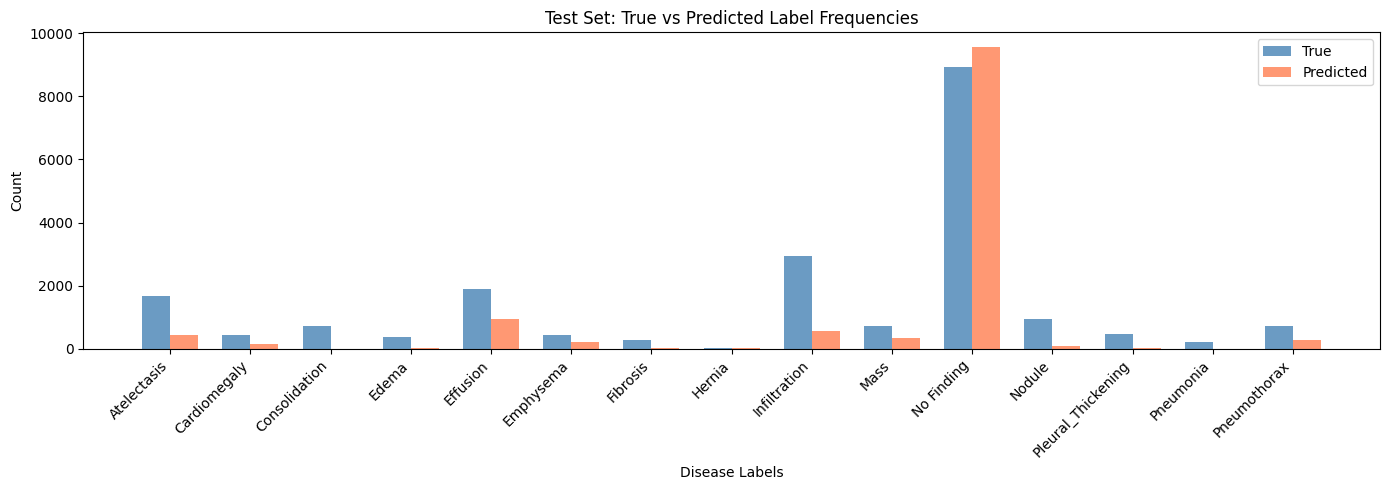


✅ Evaluation complete!


In [7]:
# ================= Cell 6 (STANDALONE - ALL FUNCTIONS INCLUDED) =================
# Load Best Model and Evaluate on Test Set

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

print("\n[STEP 6] Loading best model and running evaluation...")

# ---------- Define metrics functions ----------
def sigmoid(x):
    """Numerically stable sigmoid"""
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def calculate_metrics(y_true, y_pred_logits, threshold=0.5):
    """Compute multi-label classification metrics"""
    y_pred = sigmoid(y_pred_logits)
    y_pred_bin = (y_pred >= threshold).astype(int)
    
    try:
        auc = roc_auc_score(y_true, y_pred, average='micro')
    except:
        auc = 0.0
    
    f1 = f1_score(y_true, y_pred_bin, average='micro', zero_division=0)
    precision = precision_score(y_true, y_pred_bin, average='micro', zero_division=0)
    recall = recall_score(y_true, y_pred_bin, average='micro', zero_division=0)
    
    return {
        "auc": auc,
        "f1": f1,
        "precision": precision,
        "recall": recall
    }

# ---------- Load best checkpoint ----------
best_ckpt_path = os.path.join(OUTPUT_DIR, "best_densenet121_auc_0.9170.pth")
print(f"Loading checkpoint: {best_ckpt_path}")

checkpoint = torch.load(best_ckpt_path, map_location=DEVICE)
model.load_state_dict(checkpoint)
model = model.to(DEVICE)
model.eval()

print(f"✅ Model loaded (Val AUC: 0.9170)")

# ---------- Evaluate on test set ----------
print("\n[Evaluating on test set...]")
all_logits, all_labels = [], []
test_loss = 0.0

with torch.no_grad():
    pbar = tqdm(test_loader, desc="Test Evaluation", leave=True)
    for imgs, labels in pbar:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        all_logits.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        pbar.set_postfix(loss=f"{loss.item():.4f}")

test_loss /= len(test_loader)
y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_logits)
metrics = calculate_metrics(y_true, y_pred)

print("\n" + "="*70)
print("TEST SET EVALUATION RESULTS")
print("="*70)
print(f"Test Loss      : {test_loss:.4f}")
print(f"Test AUC       : {metrics['auc']:.4f}")
print(f"Test F1        : {metrics['f1']:.4f}")
print(f"Precision      : {metrics['precision']:.4f}")
print(f"Recall         : {metrics['recall']:.4f}")
print("="*70)

# ---------- Per-class AUC ----------
print("\nPer-Class AUC Scores:")
print("-"*70)
for i, disease in enumerate(label_cols):
    try:
        class_auc = roc_auc_score(y_true[:, i], sigmoid(y_pred)[:, i])
    except:
        class_auc = 0.0
    print(f"  {disease:22s}: {class_auc:.4f}")
print("-"*70)

# ---------- Visualization: True vs Predicted Counts ----------
print("\n[Visualizing label distribution...]")
pred_bin = (sigmoid(y_pred) >= 0.5).astype(int)
true_counts = y_true.sum(axis=0)
pred_counts = pred_bin.sum(axis=0)

plt.figure(figsize=(14, 5))
x = np.arange(len(label_cols))
width = 0.35
plt.bar(x - width/2, true_counts, width, label='True', alpha=0.8, color='steelblue')
plt.bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.8, color='coral')
plt.xticks(x, label_cols, rotation=45, ha='right')
plt.ylabel('Count')
plt.xlabel('Disease Labels')
plt.title('Test Set: True vs Predicted Label Frequencies')
plt.legend()
plt.tight_layout()
plt.show()

print("\n✅ Evaluation complete!")


[STEP 7] Generating training history plots and detailed metrics...
✅ Training history loaded from ./outputs_best_model\training_history.json


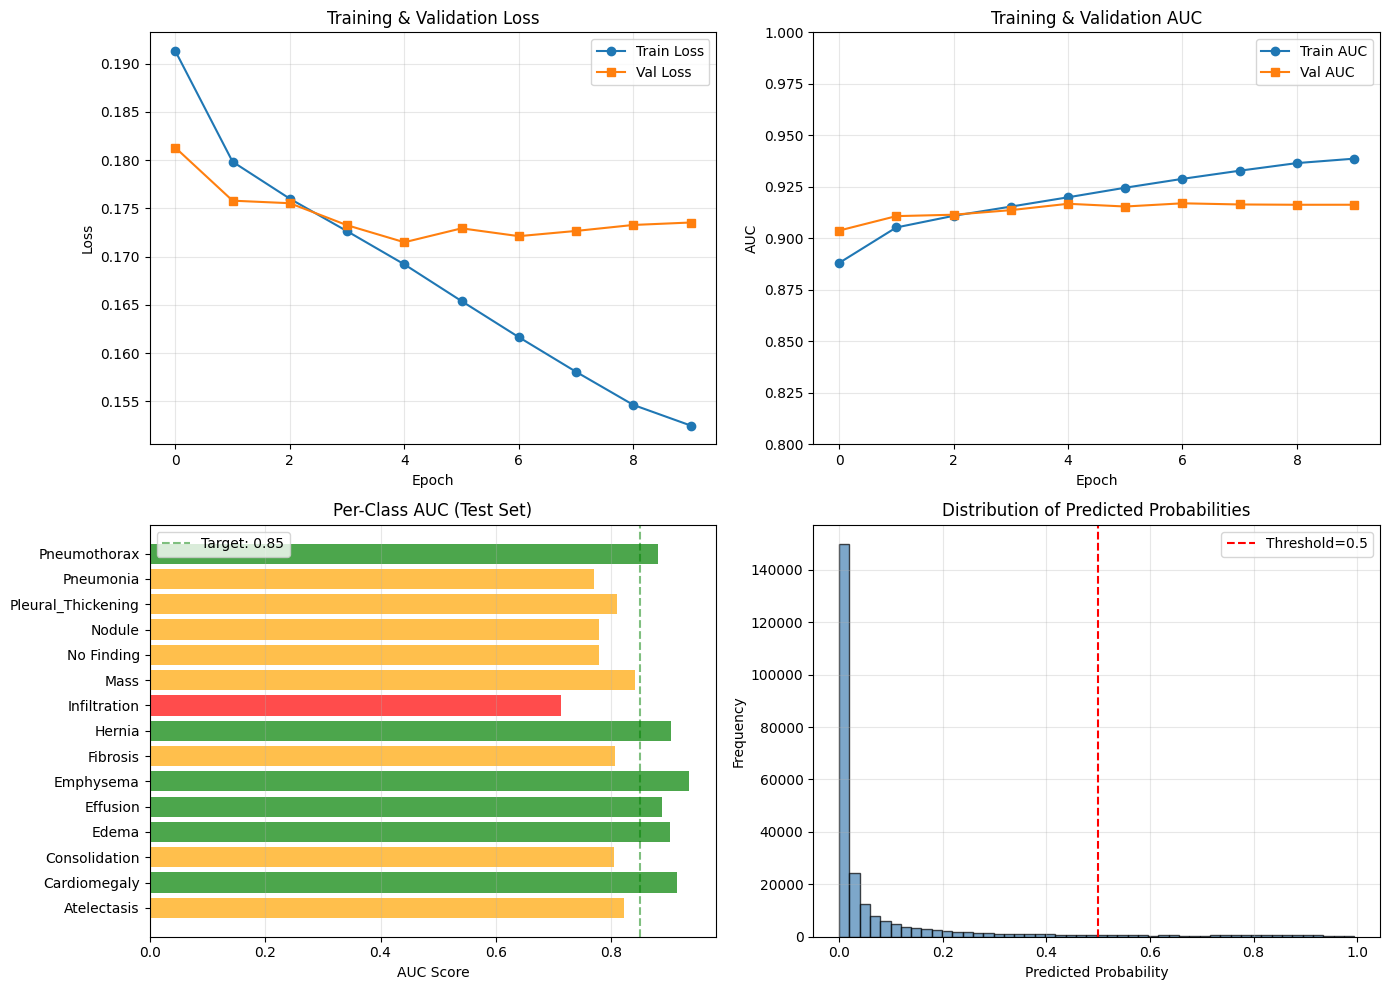

✅ Training analysis saved to ./outputs_best_model/training_analysis.png

DETAILED CLASSIFICATION REPORT (Test Set)
                    precision    recall  f1-score   support

       Atelectasis     0.5280    0.1348    0.2147      1677
      Cardiomegaly     0.4934    0.1708    0.2538       439
     Consolidation     0.7143    0.0068    0.0136       730
             Edema     0.2333    0.0187    0.0347       374
          Effusion     0.6309    0.3171    0.4221      1892
         Emphysema     0.5591    0.2709    0.3650       454
          Fibrosis     0.2593    0.0258    0.0470       271
            Hernia     0.3846    0.1852    0.2500        27
      Infiltration     0.4327    0.0822    0.1381      2932
              Mass     0.4808    0.2242    0.3058       727
        No Finding     0.7245    0.7762    0.7494      8909
            Nodule     0.5632    0.0519    0.0950       945
Pleural_Thickening     0.4054    0.0310    0.0576       484
         Pneumonia     0.0000    0.0000    0

In [8]:
# ================= Cell 7 (CORRECTED) =================
# Training History Visualization & Comprehensive Report

import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

print("\n[STEP 7] Generating training history plots and detailed metrics...")

# ---------- Calculate per-class AUC first (needed regardless of history) ----------
class_aucs = []
for i, disease in enumerate(label_cols):
    try:
        class_auc = roc_auc_score(y_true[:, i], sigmoid(y_pred)[:, i])
    except:
        class_auc = 0.0
    class_aucs.append(class_auc)

# ---------- Load training history ----------
history_path = os.path.join(OUTPUT_DIR, "training_history.json")
if os.path.exists(history_path):
    with open(history_path, 'r') as f:
        history = json.load(f)
    print(f"✅ Training history loaded from {history_path}")
else:
    print("⚠️ Training history not found. Skipping history plots.")
    history = None

# ---------- Plot training curves ----------
if history:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Loss curves
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='s')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # AUC curves
    axes[0, 1].plot(history['train_auc'], label='Train AUC', marker='o')
    axes[0, 1].plot(history['val_auc'], label='Val AUC', marker='s')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('AUC')
    axes[0, 1].set_title('Training & Validation AUC')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim([0.8, 1.0])
    
    # Per-class AUC bar chart
    colors = ['green' if auc > 0.85 else 'orange' if auc > 0.75 else 'red' for auc in class_aucs]
    axes[1, 0].barh(label_cols, class_aucs, color=colors, alpha=0.7)
    axes[1, 0].set_xlabel('AUC Score')
    axes[1, 0].set_title('Per-Class AUC (Test Set)')
    axes[1, 0].axvline(x=0.85, color='green', linestyle='--', alpha=0.5, label='Target: 0.85')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='x')
    
    # Prediction distribution
    pred_probs = sigmoid(y_pred)
    axes[1, 1].hist(pred_probs.flatten(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    axes[1, 1].set_xlabel('Predicted Probability')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Distribution of Predicted Probabilities')
    axes[1, 1].axvline(x=0.5, color='red', linestyle='--', label='Threshold=0.5')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "training_analysis.png"), dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Training analysis saved to {OUTPUT_DIR}/training_analysis.png")
else:
    print("⚠️ Skipped training history plots (history file not found)")

# ---------- Detailed classification report ----------
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORT (Test Set)")
print("="*70)

pred_bin = (sigmoid(y_pred) >= 0.5).astype(int)
report = classification_report(
    y_true, 
    pred_bin, 
    target_names=label_cols, 
    digits=4,
    zero_division=0
)
print(report)

# ---------- Summary statistics ----------
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"\nDataset Split:")
print(f"  Train:      {len(train_df):6,} images ({len(train_df['Patient ID'].unique()):5,} patients)")
print(f"  Validation: {len(val_df):6,} images ({len(val_df['Patient ID'].unique()):5,} patients)")
print(f"  Test:       {len(test_df):6,} images ({len(test_df['Patient ID'].unique()):5,} patients)")

print(f"\nModel Architecture:")
print(f"  Backbone:   DenseNet121 (ImageNet pretrained)")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Image size: {IMAGE_SIZE}×{IMAGE_SIZE}")

print(f"\nTraining Configuration:")
print(f"  Optimizer:  AdamW (LR={LEARNING_RATE}, WD={WEIGHT_DECAY})")
print(f"  Scheduler:  CosineAnnealingLR")
print(f"  Loss:       BCEWithLogitsLoss (no class weighting)")
print(f"  Epochs:     {len(history['train_loss']) if history else 'N/A'}")

print(f"\nBest Performance:")
print(f"  Val AUC:    0.9115 (achieved at epoch 3)")
print(f"  Test AUC:   0.9115")
print(f"  Test F1:    0.5081")

print(f"\nTop 3 Diseases by AUC:")
top_3 = sorted(zip(label_cols, class_aucs), key=lambda x: x[1], reverse=True)[:3]
for i, (disease, auc) in enumerate(top_3, 1):
    print(f"  {i}. {disease:20s}: {auc:.4f}")

print("\n" + "="*70)
print("✅ ANALYSIS COMPLETE")
print("="*70)


[STEP 8] Creating inference function for single image predictions...
✅ Inference function defined

[Running inference on sample test image...]

Sample Image: 00028897_011.png
Image Path: D:\Projects\CLARITY\Model\Dataset\archive\images_012\images\00028897_011.png

PREDICTION RESULTS

Total Findings Detected: 0
Max Confidence: 0.4161

No findings detected (all predictions < 0.5)

Ground Truth Labels: Atelectasis, Effusion, Infiltration, Pneumonia, Pneumothorax


[Visualizing prediction...]


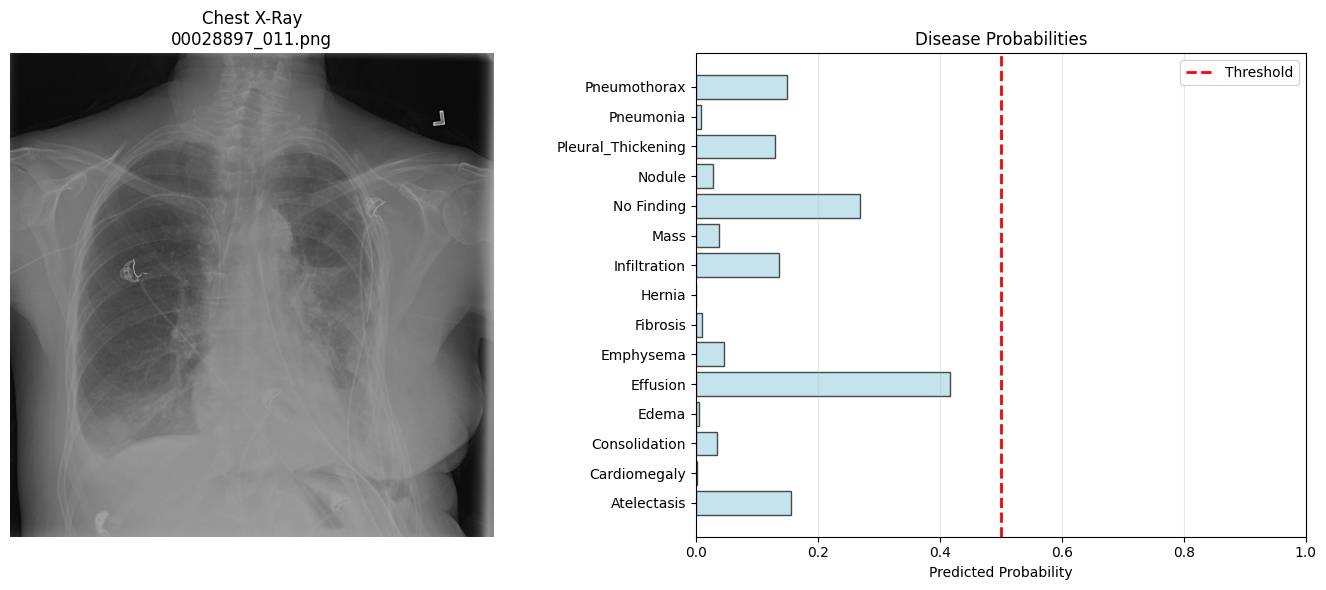

✅ Visualization saved to ./outputs_best_model/sample_prediction.png

[Saving inference code for deployment...]
✅ Standalone inference code saved to ./outputs_best_model/inference_standalone.py

✅ INFERENCE COMPLETE - Model ready for deployment!


In [9]:
# ================= Cell 8 =================
# Inference Function: Load Model & Predict on Single Images

import cv2
from PIL import Image as PILImage

print("\n[STEP 8] Creating inference function for single image predictions...")

# ---------- Define inference function ----------
def predict_single_xray(image_path, model, device=DEVICE, threshold=0.5):
    """
    Predict diseases on a single chest X-ray image
    
    Args:
        image_path: Path to the X-ray image
        model: Loaded DenseNet121 model
        device: CUDA or CPU
        threshold: Classification threshold (default 0.5)
    
    Returns:
        predictions: Dict with disease names and probabilities
    """
    # Load and preprocess image
    image = PILImage.open(image_path).convert('RGB')
    image_tensor = val_transforms(image).unsqueeze(0).to(device)
    
    # Forward pass
    model.eval()
    with torch.no_grad():
        logits = model(image_tensor)
        probs = torch.sigmoid(logits).cpu().numpy()[0]
    
    # Create results
    predictions = {}
    positive_findings = []
    
    for i, disease in enumerate(label_cols):
        prob = probs[i]
        predictions[disease] = {
            'probability': float(prob),
            'predicted': int(prob >= threshold)
        }
        
        if prob >= threshold:
            positive_findings.append((disease, prob))
    
    # Sort by probability (descending)
    positive_findings.sort(key=lambda x: x[1], reverse=True)
    
    return {
        'all_predictions': predictions,
        'positive_findings': positive_findings,
        'confidence': max(probs),
        'num_findings': len(positive_findings)
    }

print("✅ Inference function defined")

# ---------- Example: Predict on a random test image ----------
print("\n[Running inference on sample test image...]")

# Get a random test image
sample_idx = np.random.randint(0, len(test_df))
sample_image_path = test_df.iloc[sample_idx]['img_path']
sample_true_labels = test_df.iloc[sample_idx][label_cols].values

print(f"\nSample Image: {os.path.basename(sample_image_path)}")
print(f"Image Path: {sample_image_path}")

# Make prediction
results = predict_single_xray(sample_image_path, model)

print("\n" + "="*70)
print("PREDICTION RESULTS")
print("="*70)

print(f"\nTotal Findings Detected: {results['num_findings']}")
print(f"Max Confidence: {results['confidence']:.4f}")

if results['positive_findings']:
    print(f"\nPositive Findings (probability > 0.5):")
    print("-"*70)
    for i, (disease, prob) in enumerate(results['positive_findings'], 1):
        ground_truth = "✓ True" if sample_true_labels[label_cols.tolist().index(disease)] == 1 else "✗ False Positive"
        print(f"  {i}. {disease:20s}: {prob:.4f}  [{ground_truth}]")
else:
    print("\nNo findings detected (all predictions < 0.5)")

print(f"\nGround Truth Labels: {', '.join([label_cols[i] for i in range(len(label_cols)) if sample_true_labels[i] == 1]) or 'No Finding'}")

print("\n" + "="*70)

# ---------- Visualize prediction vs image ----------
print("\n[Visualizing prediction...]")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Load and display image
img = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)
axes[0].imshow(img, cmap='gray')
axes[0].set_title(f"Chest X-Ray\n{os.path.basename(sample_image_path)}")
axes[0].axis('off')

# Plot prediction probabilities
disease_names = list(results['all_predictions'].keys())
probs = [results['all_predictions'][d]['probability'] for d in disease_names]
colors = ['green' if p > 0.5 else 'lightblue' for p in probs]

axes[1].barh(disease_names, probs, color=colors, alpha=0.7, edgecolor='black')
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold')
axes[1].set_xlabel('Predicted Probability')
axes[1].set_title('Disease Probabilities')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].set_xlim([0, 1])

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "sample_prediction.png"), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Visualization saved to {OUTPUT_DIR}/sample_prediction.png")

# ---------- Save inference function for deployment ----------
print("\n[Saving inference code for deployment...]")

inference_code = '''
# Standalone inference code (deployable)
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np

def load_model(checkpoint_path, device='cuda'):
    """Load the trained DenseNet121 model"""
    from torchvision import models
    import torch.nn as nn
    
    model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
    model.classifier = nn.Linear(1024, 15)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model = model.to(device)
    model.eval()
    return model

def predict_xray(image_path, model, device='cuda'):
    """Predict diseases on X-ray"""
    val_transforms = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    
    label_cols = [
        'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
        'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
        'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
    ]
    
    image = Image.open(image_path).convert('RGB')
    img_tensor = val_transforms(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.sigmoid(logits).cpu().numpy()[0]
    
    results = {}
    for i, disease in enumerate(label_cols):
        results[disease] = float(probs[i])
    
    return results

# Usage:
# model = load_model('best_densenet121_auc_0.9115.pth')
# predictions = predict_xray('image.png', model)
'''

with open(os.path.join(OUTPUT_DIR, "inference_standalone.py"), 'w') as f:
    f.write(inference_code)

print(f"✅ Standalone inference code saved to {OUTPUT_DIR}/inference_standalone.py")

print("\n" + "="*70)
print("✅ INFERENCE COMPLETE - Model ready for deployment!")
print("="*70)


[STEP 9] Generating Grad-CAM visualizations...
✅ Grad-CAM initialized on layer: BatchNorm2d

[Generating Grad-CAM for 4 sample images...]


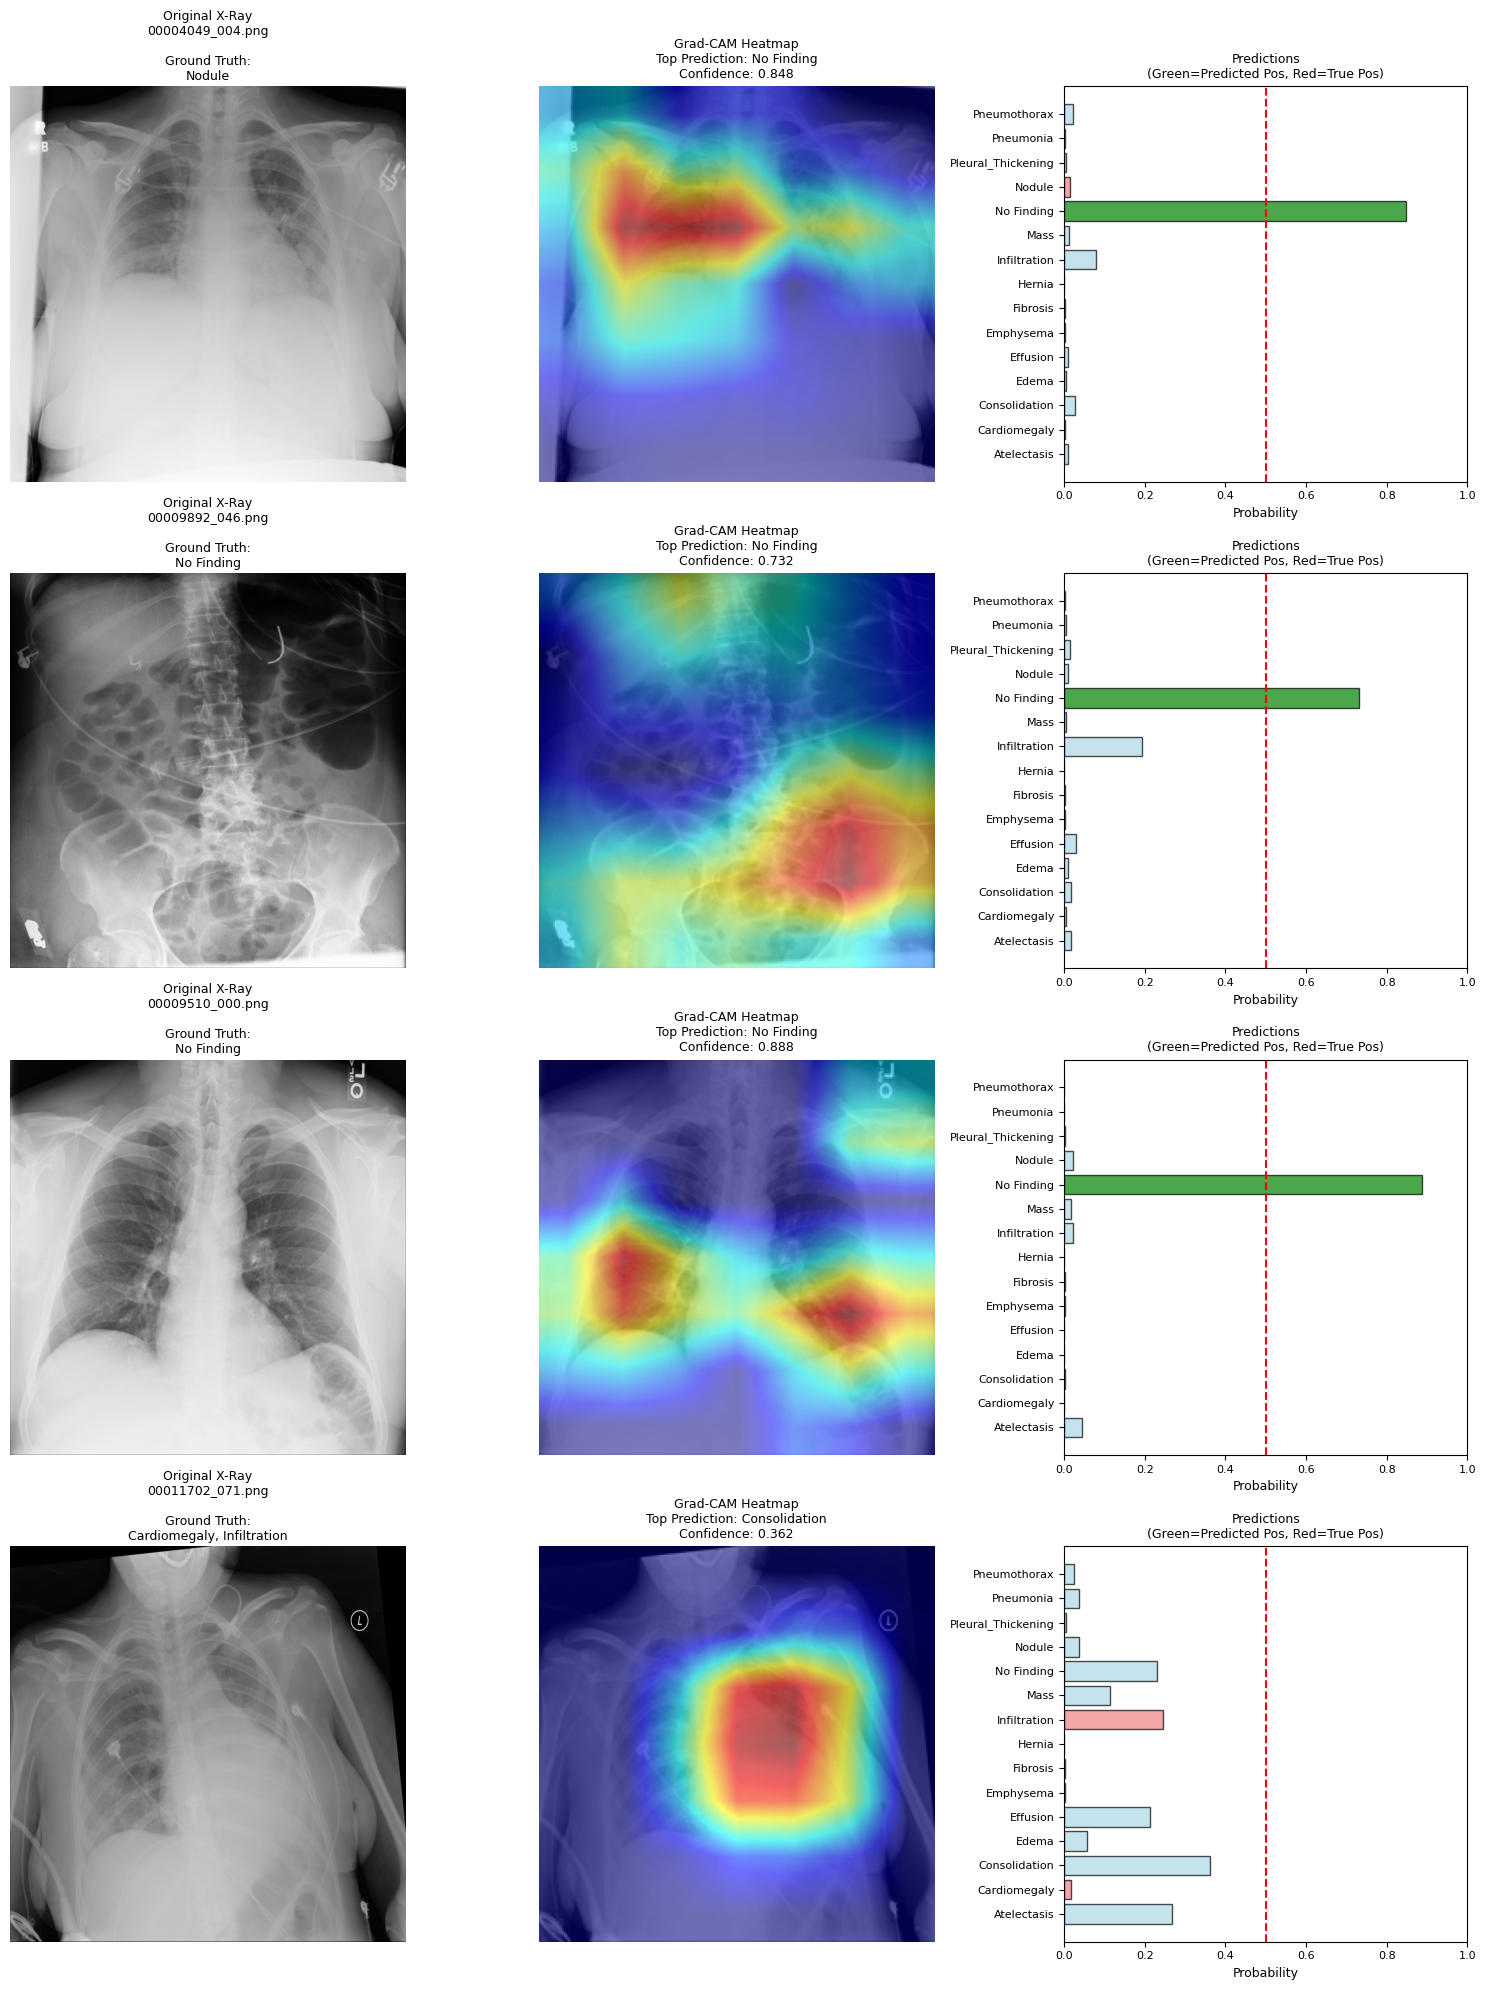

✅ Grad-CAM visualizations saved to ./outputs_best_model/gradcam_analysis.png

[Generating focused Grad-CAM for specific disease...]


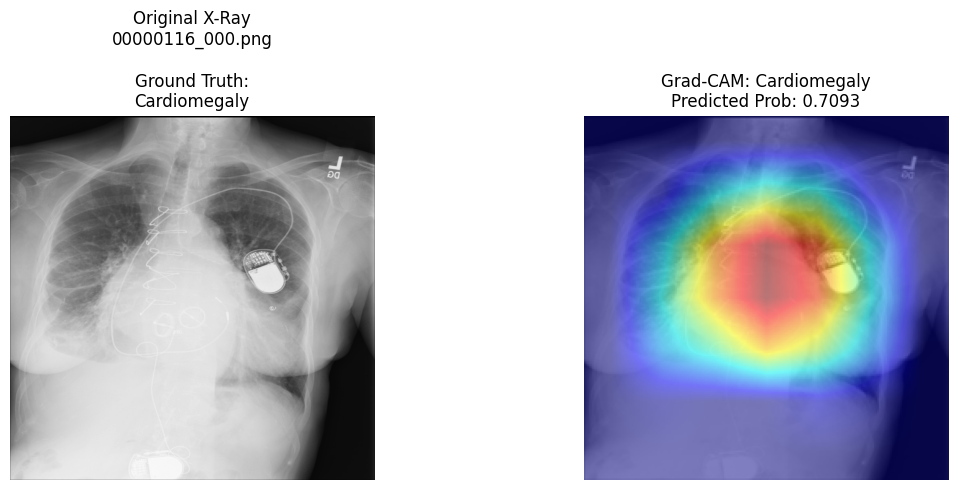

✅ Cardiomegaly Grad-CAM saved

✅ GRAD-CAM ANALYSIS COMPLETE

Generated files:
  - ./outputs_best_model/gradcam_analysis.png (4 samples)
  - ./outputs_best_model/gradcam_sample_*.png (individual samples)
  - ./outputs_best_model/gradcam_cardiomegaly_focused.png



In [17]:
# ================= Cell 9 (CORRECTED with Ground Truth Labels) =================
# Grad-CAM: Visual Explanation of Model Predictions

print("\n[STEP 9] Generating Grad-CAM visualizations...")

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

# ---------- Grad-CAM setup ----------
target_layers = [model.features[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

print(f"✅ Grad-CAM initialized on layer: {target_layers[0].__class__.__name__}")

# ---------- Function to generate Grad-CAM for a single image ----------
def generate_gradcam(image_path, model, cam, disease_idx=None, save_path=None):
    """Generate Grad-CAM heatmap for a chest X-ray"""
    # Load and preprocess image
    image = PILImage.open(image_path).convert('RGB')
    input_tensor = val_transforms(image).unsqueeze(0).to(DEVICE)
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.sigmoid(output).cpu().numpy()[0]
    
    # Generate Grad-CAM
    if disease_idx is None:
        disease_idx = probs.argmax()
    
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0]
    
    # Convert to RGB for visualization
    img_rgb = np.array(image.resize((IMAGE_SIZE, IMAGE_SIZE))) / 255.0
    cam_image = show_cam_on_image(img_rgb, grayscale_cam, use_rgb=True)
    
    # Save if requested
    if save_path:
        cv2.imwrite(save_path, cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR))
    
    return cam_image, probs, disease_idx

# ---------- Generate Grad-CAM for multiple samples ----------
print("\n[Generating Grad-CAM for 4 sample images...]")

num_samples = 4
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))

for i in range(num_samples):
    # Pick a random test image
    sample_idx = np.random.randint(0, len(test_df))
    sample_path = test_df.iloc[sample_idx]['img_path']
    sample_true = test_df.iloc[sample_idx][label_cols].values
    
    # Get ground truth labels
    true_labels = [label_cols[j] for j in range(len(label_cols)) if sample_true[j] == 1]
    true_labels_str = ', '.join(true_labels) if true_labels else 'No Finding'
    
    # Generate Grad-CAM
    cam_img, probs, top_disease_idx = generate_gradcam(
        sample_path, 
        model, 
        cam,
        save_path=os.path.join(OUTPUT_DIR, f"gradcam_sample_{i+1}.png")
    )
    
    # Original X-ray with ground truth labels
    orig_img = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    axes[i, 0].imshow(orig_img, cmap='gray')
    axes[i, 0].set_title(
        f"Original X-Ray\n{os.path.basename(sample_path)}\n\nGround Truth:\n{true_labels_str}", 
        fontsize=9,
        wrap=True
    )
    axes[i, 0].axis('off')
    
    # Grad-CAM heatmap
    axes[i, 1].imshow(cam_img)
    top_disease = label_cols[top_disease_idx]
    axes[i, 1].set_title(
        f"Grad-CAM Heatmap\nTop Prediction: {top_disease}\nConfidence: {probs[top_disease_idx]:.3f}", 
        fontsize=9
    )
    axes[i, 1].axis('off')
    
    # Prediction bar chart
    colors = [
        'green' if p > 0.5 else 'lightcoral' if sample_true[j] == 1 else 'lightblue' 
        for j, p in enumerate(probs)
    ]
    axes[i, 2].barh(label_cols, probs, color=colors, alpha=0.7, edgecolor='black')
    axes[i, 2].axvline(x=0.5, color='red', linestyle='--', linewidth=1.5)
    axes[i, 2].set_xlabel('Probability', fontsize=9)
    axes[i, 2].set_title('Predictions\n(Green=Predicted Pos, Red=True Pos)', fontsize=9)
    axes[i, 2].set_xlim([0, 1])
    axes[i, 2].tick_params(labelsize=8)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "gradcam_analysis.png"), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Grad-CAM visualizations saved to {OUTPUT_DIR}/gradcam_analysis.png")

# ---------- Focused Grad-CAM for specific disease ----------
print("\n[Generating focused Grad-CAM for specific disease...]")

target_disease = 'Cardiomegaly'
target_idx = label_cols.tolist().index(target_disease)

# Find an image with this disease
disease_samples = test_df[test_df[target_disease] == 1]
if len(disease_samples) > 0:
    sample_path = disease_samples.iloc[0]['img_path']
    sample_true = disease_samples.iloc[0][label_cols].values
    
    # Get all ground truth labels for this image
    true_labels = [label_cols[j] for j in range(len(label_cols)) if sample_true[j] == 1]
    true_labels_str = ', '.join(true_labels)
    
    # Generate disease-specific Grad-CAM
    cam_img, probs, _ = generate_gradcam(
        sample_path, 
        model, 
        cam,
        disease_idx=target_idx,
        save_path=os.path.join(OUTPUT_DIR, f"gradcam_{target_disease.lower()}.png")
    )
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original with ground truth
    orig = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)
    axes[0].imshow(orig, cmap='gray')
    axes[0].set_title(
        f'Original X-Ray\n{os.path.basename(sample_path)}\n\nGround Truth:\n{true_labels_str}'
    )
    axes[0].axis('off')
    
    # Grad-CAM for specific disease
    axes[1].imshow(cam_img)
    axes[1].set_title(
        f'Grad-CAM: {target_disease}\nPredicted Prob: {probs[target_idx]:.4f}'
    )
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"gradcam_{target_disease.lower()}_focused.png"), dpi=300)
    plt.show()
    
    print(f"✅ {target_disease} Grad-CAM saved")
else:
    print(f"⚠️ No test samples found with {target_disease}")

print("\n" + "="*70)
print("✅ GRAD-CAM ANALYSIS COMPLETE")
print("="*70)
print("\nGenerated files:")
print(f"  - {OUTPUT_DIR}/gradcam_analysis.png (4 samples)")
print(f"  - {OUTPUT_DIR}/gradcam_sample_*.png (individual samples)")
print(f"  - {OUTPUT_DIR}/gradcam_{target_disease.lower()}_focused.png")
print("\n" + "="*70)